# Deconvolution of the PAT current and transimpedance fitting

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi, e, hbar, h
from scipy import interpolate, ndimage, signal, optimize, linalg

# data.py from qtplot (github.com/Rubenknex/qtplot)
from data2 import DatFile, Data2D
import pat_functions as pat

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [2]:
def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

### Importing the data and initial processing

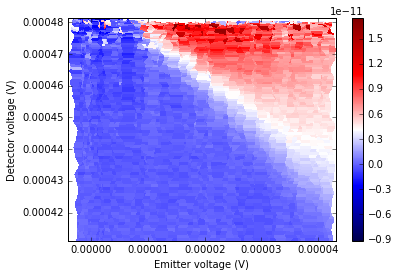

In [85]:
name = '930.npy'
if name[-3:] == 'dat':
    v_meas = True
else:
    v_meas = False

if v_meas:
    df = DatFile(name)
    data = df.get_data('V_meas_EMI (V)', 'V_meas_DET (V)', 'I_meas_DET (A)', 'dac1 (Vbias_NW)', 'dac2 (Vbias(uV)_DET)')

    # Subtract a linecut and scale/flip the data into positive coords/values
    V_DET_offset = -56.35e-6
    V_NW_offset = 2.5e-6
    data.offset_axes(x_offset=-V_NW_offset, y_offset=-V_DET_offset)

    data.sub_linecut(type='vertical', position=0)

    plt.xlabel('Emitter voltage (V)')
    plt.ylabel('Detector voltage (V)')
    plt.pcolormesh(*data.get_pcolor(), cmap='seismic')
    plt.colorbar()
    plt.gca().axis('tight')
else:
    data2 = np.load(name)
    data2[:,:,0] = np.multiply(data2[:,:,0],1e-6)
#     data2 = np.reshape(data2, (len(data2[0,:,1]),len(data2[:,0,1]),3))
    
    plt.xlabel('Emitter voltage (V)')
    plt.ylabel('Detector voltage (V)')
    plt.pcolormesh(data2[:,:,1],data2[:,:,0],data2[:,:,2], cmap='seismic')
    plt.colorbar()
    plt.gca().axis('tight')

### Construction of an I<sub>QP,0</sub> curve and interpreting I<sub>PAT</sub> on uniformly spaced voltages
The deconvolution algorithm needs uniformly spaced datapoints so we linearly interpolate $I_\mathrm{PAT}$ into a new array with the average voltage step.

In [125]:
# Choose a column
pat_index = 20

# The PAT current for a certain emitter voltage
if v_meas:
    V_PAT, I_PAT = data.y[::-1,pat_index], data.z[::-1,pat_index]
else:
    V_PAT, I_PAT = data2[pat_index,:,0], data2[pat_index,:,2]

# Use the average voltage difference for the uniform spacing
dV = np.average(np.diff(V_PAT))
dw = (e*dV)/hbar

# Values extracted from the measured I_QP0
two_delta = 475e-6 + (9e9*h)/e # 3.4GHz frequency offset to fit theory
G_N = 1/5000.0
offset = 0e-6
# print(two_delta)

# Construct a QP0 curve as a piecewise function and then smooth it
V_QP0 = np.arange(200e-6, 700e-6, dV)
I_QP0_sim = np.piecewise(V_QP0, [V_QP0 < two_delta, V_QP0 >= two_delta], [0, lambda x: G_N * (x - offset)])
I_QP0_smooth = ndimage.filters.gaussian_filter1d(I_QP0_sim, 16)

# Interpret I_PAT onto the uniform points
V_PAT_interp = V_QP0.copy()
I_PAT_interp = np.interp(V_PAT_interp, V_PAT, I_PAT, left=np.nan, right=np.nan)

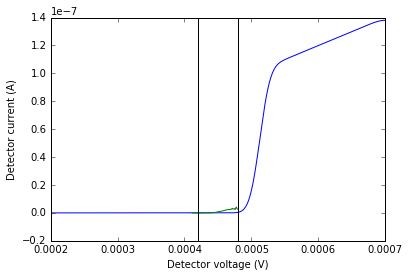

In [126]:
# These indices mark the part of I_PAT that will be deconvoluted
V_start = 420e-6
V_end = 479e-6

V_min = find_nearest(V_PAT_interp, V_start)
V_max = find_nearest(V_PAT_interp, V_end)
size = V_max - V_min

plt.xlabel('Detector voltage (V)')
plt.ylabel('Detector current (A)')
plt.plot(V_QP0, I_QP0_smooth)
plt.plot(V_PAT_interp, I_PAT_interp*3e2)
plt.axvline(V_PAT_interp[V_min], c='k')
plt.axvline(V_PAT_interp[V_max], c='k')

### Functions for deconvolution and fitting

In [127]:
def deconvolute(qp0, measured, tikhonov):
    """
    Deconvolute the PAT current using Tikhonov regularization.
    """
    A = linalg.tril(linalg.toeplitz(qp0))
    A = np.concatenate((A, tikhonov * np.identity(A.shape[0])))

    b = np.concatenate((measured, np.zeros(len(measured))))
    
    x, residual = optimize.nnls(A, b)

    return x, residual

def single_frequency_PAT(V_QP0, I_QP0, omega, Z, I_c):
    """
    Create a single-frequency PAT current. This is done by shifting I_QP0 left
    according to the frequency and scaling by a number of constants including
    the transimpedance Z, critical current I_c and frequency.
    """
    V_shift = (hbar*omega)/e
    shifted = np.interp((V_QP0 + V_shift), V_QP0, I_QP0, right=np.nan)

    return ((Z**2)/(8*pi)) * (I_c/V_shift)**2 * shifted

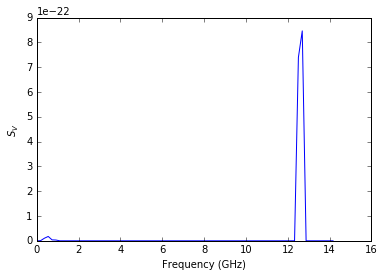

In [128]:
I_QP0_part = I_QP0_smooth[V_max:V_max+size]
I_PAT_part = I_PAT_interp[V_min:V_max]

x, residuals = deconvolute(I_QP0_part, I_PAT_part, 1e-9)

omegas = np.arange(0, size, 1) * dw
frequencies = omegas / (2 * pi)
S_v = x[::-1] / (dw * (e/(hbar*omegas))**2 * (1/(2*pi)))

plt.xlabel('Frequency (GHz)')
plt.ylabel('$S_V$')
plt.plot(frequencies / 1e9, S_v)

### Calculate the spectrum for every emitter voltage

78


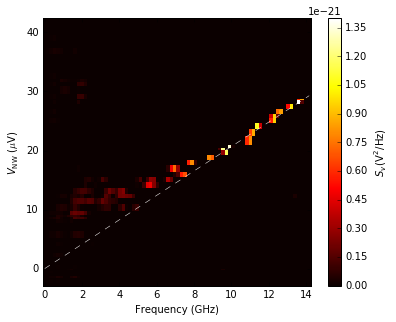

In [129]:
start, end = 0, len(data2[:,0,2])
Sv_vs_V = np.zeros((end, size))
print(size)

# Loop over every column and calculate the spectrum
for i in range(start, end):  
    if v_meas:
        V_PAT, I_PAT = data.y[::-1,i], data.z[::-1,i]
    else:
        V_PAT, I_PAT = data2[i,:,0], data2[i,:,2]    
    
    I_PAT_interp = np.interp(V_PAT_interp, V_PAT, I_PAT, left=np.nan, right=np.nan)
    
    I_QP0_part = I_QP0_smooth[V_max:V_max+size]
    I_PAT_part = I_PAT_interp[V_min:V_max]
    
    x, residuals = deconvolute(I_QP0_part, I_PAT_part, 1e-9)
    
    omegas = np.arange(0, size, 1) * dw
    frequencies = omegas / (2 * pi)
    Sv = x[::-1] / (dw * (e/(hbar*omegas))**2 * (1/(2*pi)))
    
    Sv_vs_V[i,:] = Sv

# The last column contains high values that bias the colormap
Sv_vs_V[:,-1] = 0

# The Data2D class comes in useful for plotting non-uniform data
x_coords = np.tile(frequencies, (end, 1)) / 1e9
y_coords = np.tile(np.average(data2[:,:,1], axis=1)[:,np.newaxis], (1,size)) / 1e-6
spectra = Data2D(x_coords, y_coords, Sv_vs_V)

plt.figure(figsize=(1.5*4, 1.5*3.2))
plt.xlabel('Frequency (GHz)')
plt.ylabel('$V_\mathrm{NW}$ ($\mathrm{\mu V}$)')
plt.pcolormesh(*spectra.get_pcolor(), cmap='hot', rasterized=True)
plt.colorbar().set_label('$S_v \mathrm{(V^2/Hz)}$')
plt.gca().axis('tight')
plt.ylim(np.min(y_coords),np.max(y_coords))

# Theoretical frequency dependence
x = np.linspace(0, np.max(x_coords))
y = x * 1e9 * h / (2 * e)
plt.plot(x, y / 1e-6, '--', c='w', linewidth=0.5)

plt.savefig('Sv_vs_V.pdf', bbox_inches='tight')

### Transimpedance by fitting a single-frequency I<sub>PAT</sub>

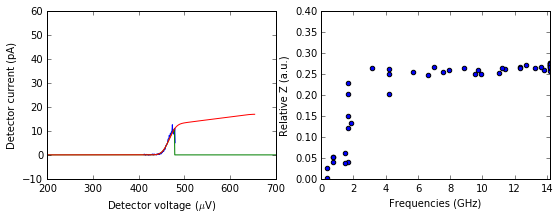

In [130]:
start, end = 0, len(data2[:,0,2])
#start, end = pat_index, pat_index + 1
freqs = []
impedances = []

for i in range(start, end):
    if v_meas:
        V_PAT, I_PAT = data.y[::-1,i], data.z[::-1,i]
    else:
        V_PAT, I_PAT = data2[i,:,0], data2[i,:,2]    
    
    I_PAT_interp = np.interp(V_PAT_interp, V_PAT, I_PAT, left=np.nan, right=np.nan)
    
    I_QP0_part = I_QP0_smooth[V_max:V_max+size]
    I_PAT_part = I_PAT_interp[V_min:V_max]
    
    x, residuals = deconvolute(I_QP0_part, I_PAT_part, 1e-9)
    
    omegas = np.arange(0, size, 1) * dw
    frequencies = omegas / (2 * pi)
    Sv = x[::-1] / (dw * (e/(hbar*omegas))**2 * (1/(2*pi)))
    
    # Calculate the frequency according to theory
    if v_meas:
        V_emi = np.average(data.x[:,i])
    else:
        V_emi = np.average(data2[i,:,1])
    f_theory = (2 * e * V_emi) / h
    
    # Create a subset of width 10 GHz around the theoretical frequency
    # this is to make sure the single-freq fit try to fit to
    # other frequencies present in the spectrum
    Sv_subset = Sv.copy()
    Sv_subset[frequencies < f_theory - 5e9] = 0
    Sv_subset[frequencies > f_theory + 5e9] = 0
    
    # Recalculate I_PAT from the spectrum subset
    V_backcalc, I1_backcalc, _, _, _, _ = pat.spectrum_PAT(V_QP0, I_QP0_smooth, omegas, Sv_subset, int(V_min), int(V_max))
    
    # Arbitrary because I_c through the nanowire junction is not known
    # at the moment
    I_c = 1e-8
    
    # Create a function for a single frequency to fit the data
    def make_PAT_model(omega):
        def PAT_model(V, Z):
            I_calc = single_frequency_PAT(V_QP0, I_QP0_smooth, omega, Z, I_c)
            f = interpolate.interp1d(V_QP0, I_calc)

            return f(V)

        return PAT_model
    
    # Use the peak in the spectrum as the frequency to fit
    f_peak = frequencies[np.argmax(Sv_subset)]
    w_peak = f_peak * 2 * pi
    
    # An initial guess to guide the fit
    guess = [1e3]
    
    try:
        popt, pcov = optimize.curve_fit(make_PAT_model(w_peak), V_backcalc[V_min+2:V_max-2], I1_backcalc[V_min+2:V_max-2], guess)
    except RuntimeError:
        peak_f = 0
        popt = [0]
    
    freqs.append(f_peak)
    impedances.append(popt[0])
    
    # Example fit
    if i == 25:
        plt.figure(figsize=(9, 3))
        plt.subplot(1, 2, 1)
        plt.ylim(-10, 60)
        #plt.title('Example fit')
        plt.xlabel('Detector voltage ($\mathrm{\mu}$V)')
        plt.ylabel('Detector current (pA)')
        #plt.plot(V_QP0, I_QP0_smooth)
        plt.plot(V_PAT_interp / 1e-6, I_PAT_interp / 1e-12, label='$I_{PAT}$')
        plt.plot(V_backcalc / 1e-6, I1_backcalc / 1e-12, label='$I_{PAT,fit}$')
        I = single_frequency_PAT(V_QP0, I_QP0_smooth, w_peak, popt[0], I_c)
        plt.plot(V_QP0 / 1e-6, I / 1e-12, label='$I_{PAT,subset}$')
#         plt.legend()

plt.subplot(1, 2, 2)
#plt.title('Transimpedances')
plt.xlabel('Frequencies (GHz)')
plt.xlim(0, np.max(freqs)/1e9)
plt.ylabel('Relative Z (a.u.)')
plt.ylim(0, 0.4)
freqs = np.array(freqs)
impedances = np.array(impedances)
plt.scatter(freqs / 1e9, impedances / np.max(impedances))

#plt.savefig('relative_z.pdf', bbox_inches='tight')

In [47]:
string = 'test.dat'
print(v_meas)

False
